# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import datetime
from datetime import date
from datetime import timedelta

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Сразу видим что:
1. большинство столбцов имеют тип object - следовательно нужно их преобразовывать для использования в модели
2. наименования столбцов неудобны для работы. Необходимо их унифицировать в написании и убрать заглавные буквы
3. есть столбцы с пропусками, которые необходимо обработать

напишем функцию для унификации наименований столюцов датафрейма

In [6]:
def columns_naming(df):
    df_columns = df.columns
    new_columns = []
    for column in df_columns:
        column = column.lower()
        column = column.replace(" ","_")
        new_columns.append(column)
    df.columns = new_columns
    return df

In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


переименуем столбцы в таблицах train и test

In [12]:
df_train = columns_naming(df_train)
df_test = columns_naming(df_test)

In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
30219,id_3252,Vienna,['Italian'],3254.0,NaN,4.0,"[[], []]",/Restaurant_Review-g190454-d4551268-Reviews-Bu...,d4551268,1,4.5
34681,id_370,Krakow,"['European', 'Grill', 'Polish', 'Bar', 'Cafe',...",371.0,$,27.0,"[['Kazimir Restaurant Bar', 'Good Atmosphere']...",/Restaurant_Review-g274772-d12091331-Reviews-K...,d12091331,1,4.5
26611,id_587,Milan,"['Italian', 'Bar', 'Barbecue', 'Pub', 'Vegetar...",588.0,$$ - $$$,659.0,"[['Great beer selection and good food', 'Great...",/Restaurant_Review-g187849-d8002075-Reviews-7_...,d8002075,1,4.0
10209,id_3022,Rome,['Pizza'],3023.0,NaN,42.0,"[[], []]",/Restaurant_Review-g187791-d3873744-Reviews-Me...,d3873744,1,4.5
44329,id_509,Warsaw,"['Polish', 'Cafe', 'Eastern European', 'Europe...",510.0,$$ - $$$,31.0,"[['Cute little place', ""It's not really a cafe...",/Restaurant_Review-g274856-d8042517-Reviews-Kr...,d8042517,1,4.5


In [16]:
data.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [17]:
data['number_of_reviews_isNAN'] = pd.isna(data.number_of_reviews).astype('uint8')
data['price_range_isNAN'] = pd.isna(data.price_range).astype('uint8')
data['cuisine_style_isNAN'] = pd.isna(data.cuisine_style).astype('uint8')
data['reviews_isNAN'] = pd.isna(data.reviews).astype('uint8')

Попробуем более детально посмотреть пропуски и понять на что их можно заменить. Удалять мы их не будем - так как это запрещено условиями задачи.

## 2. Обработка признаков, Feature Engeneering

Рассмотри колонку cuisine_style и выделим в ней уникалные кухни

In [18]:
unique_cuisines = data[~data.cuisine_style.isna()]['cuisine_style'].astype('str').apply(lambda x: eval(x)).explode()
unique_cuisines_counts = unique_cuisines.value_counts()

In [19]:
print(unique_cuisines_counts)
print(len(unique_cuisines_counts))

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Polynesian                 2
Burmese                    1
Latvian                    1
Salvadoran                 1
Xinjiang                   1
Name: cuisine_style, Length: 125, dtype: int64
125


Мы видим, что у нас 125 уникальных кухонь. Наиболее часто встречающаяся из них - Vegetarian Friendly.
Помимо этого, мы видим, что в конце списка представлены кухни встречающиеся в очень малом количестве ресторанов. Попробуем рассмотреть их в графическом виде.

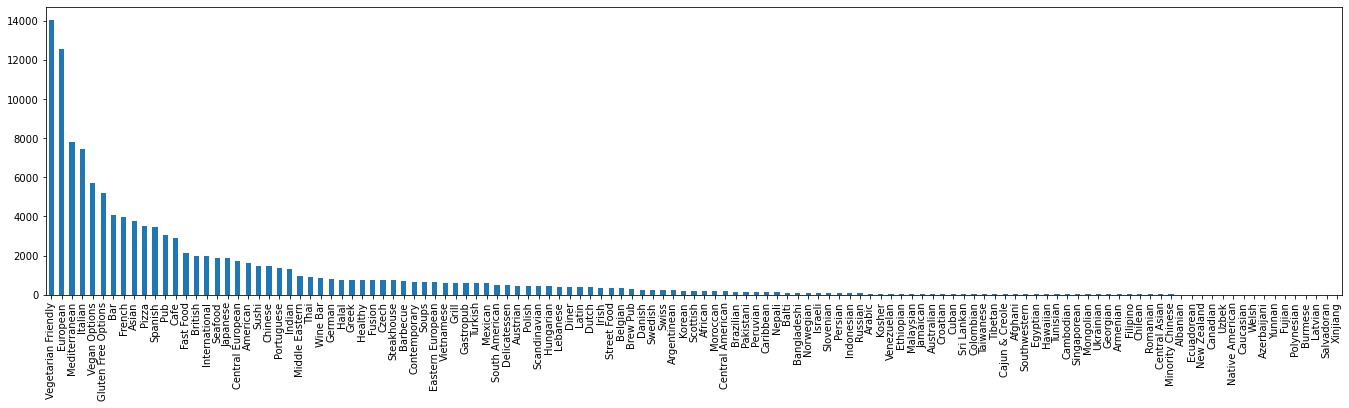

In [20]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
unique_cuisines.value_counts().plot(kind='bar')

мы видим, что большинство кухонь представлены в очень малом количестве ресторанов и не имею для нас практического значения. их можно объединить в группу Other Cuisines. Попробуем оставить кухни присутствующие минимум в 95% ресторанов. Данный параметр будем менять в дальнейшем, для улучшени результата модели.

In [21]:
cut_cuisines_limit = len(data.id_ta)*0.05 #этот параметр будем подбирать

main_cuisines = list(unique_cuisines_counts[unique_cuisines_counts > cut_cuisines_limit].index)
other_cuisines = list(set(unique_cuisines_counts.index) - set(main_cuisines))

main_cuisines

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza',
 'Spanish',
 'Pub',
 'Cafe']

пропуски в кухнях на данном этапе отнесем к Other Cusines так же как и незначительные кухни

In [22]:
data.cuisine_style = data.cuisine_style.fillna("['Other Cuisines']")
other_cuisines.append('Other Cuisines')

Заменим данные в колонке cuisine_style и прдставим их в виде dummy-переменной и причешем наименования колонок

In [23]:
for item in main_cuisines:
    data[item] = data.cuisine_style.astype('str').apply(lambda x: 1 if item in x else 0)


def other_cuisine(cuisine):
    for item in other_cuisines:
        if item in cuisine:
            return 1
    return 0


data['other_cuisines'] = data.cuisine_style.astype('str').apply(other_cuisine)

data = columns_naming(data)

следующий признак ranking

In [24]:
data.ranking.describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

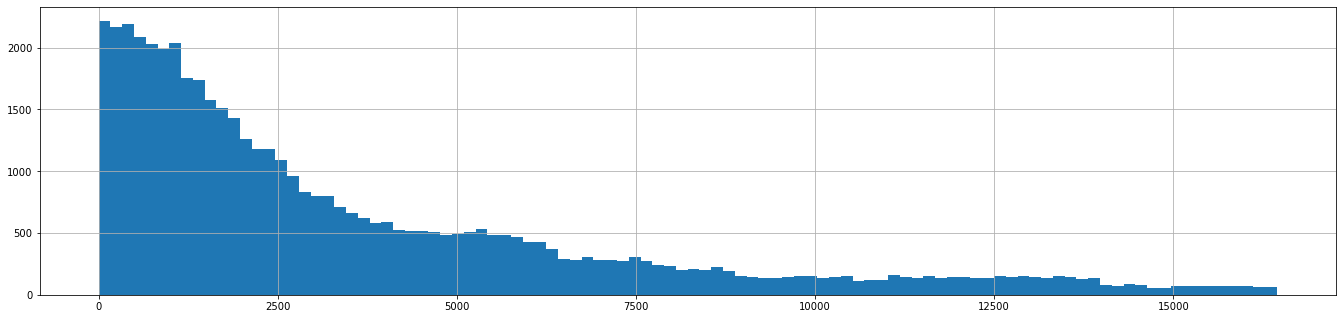

In [25]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
data.ranking.hist(bins=100)

Разброс значений достаточно большой. Мы видим, что разница между верхним квартилем и максимумом около 11000 при верхнем квартиле 5241. Так как ranking - это показатель внутри города, попробуем посмотреть на разбивку внутри основных городов. Из информации ниже, мы видим, что города с самым большим количеством ресторанов - это Лондон, Париж, Мадрид, Барселона и т.д.

In [26]:
main_cities = data.city.value_counts()[0:5]
main_cities

London       7193
Paris        6108
Madrid       3813
Barcelona    3395
Berlin       2705
Name: city, dtype: int64

In [27]:
data[data.city == 'London'].ranking.describe()

count     7193.000000
mean      8169.707354
std       4723.964027
min          1.000000
25%       4101.000000
50%       8092.000000
75%      12282.000000
max      16444.000000
Name: ranking, dtype: float64

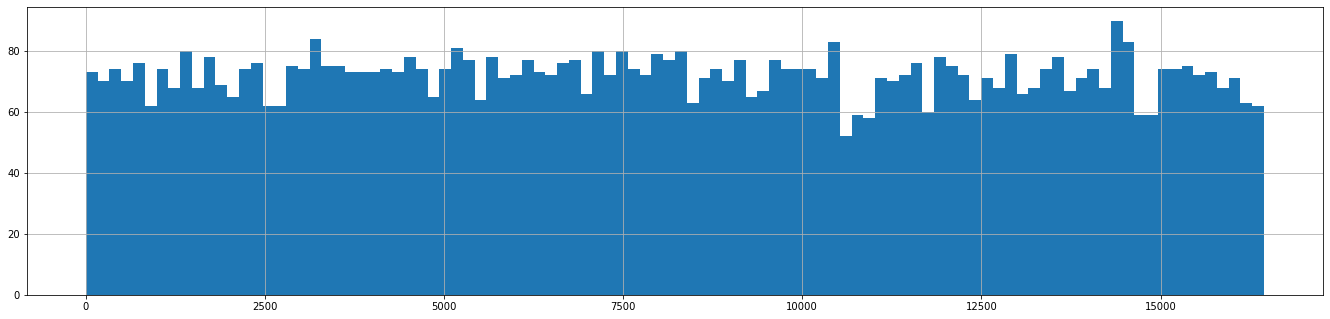

In [28]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
data[data.city == 'London'].ranking.hist(bins=100)

In [29]:
data[data.city == 'Paris'].ranking.describe()

count     6108.000000
mean      6938.557138
std       4039.932752
min          3.000000
25%       3450.750000
50%       6860.500000
75%      10417.750000
max      13986.000000
Name: ranking, dtype: float64

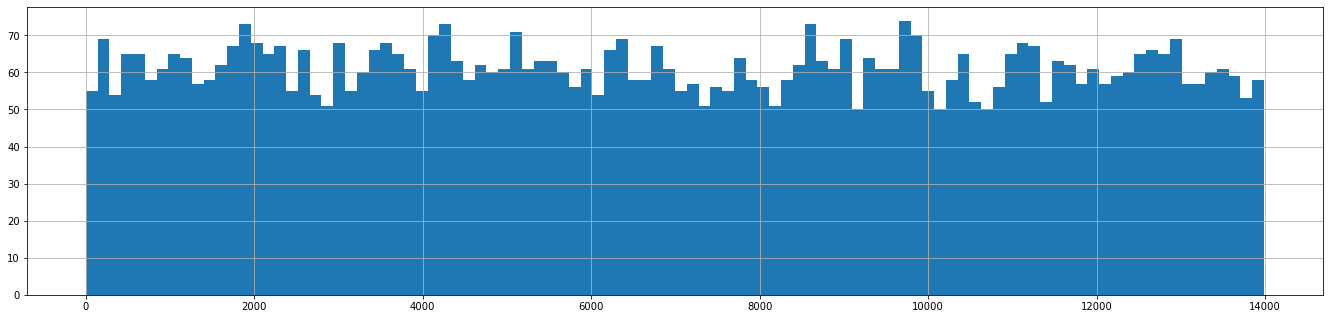

In [30]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
data[data.city == 'Paris'].ranking.hist(bins=100)

In [31]:
data[data.city == 'Madrid'].ranking.describe()

count    3813.000000
mean     4388.516391
std      2527.656287
min         1.000000
25%      2207.000000
50%      4363.000000
75%      6586.000000
max      8809.000000
Name: ranking, dtype: float64

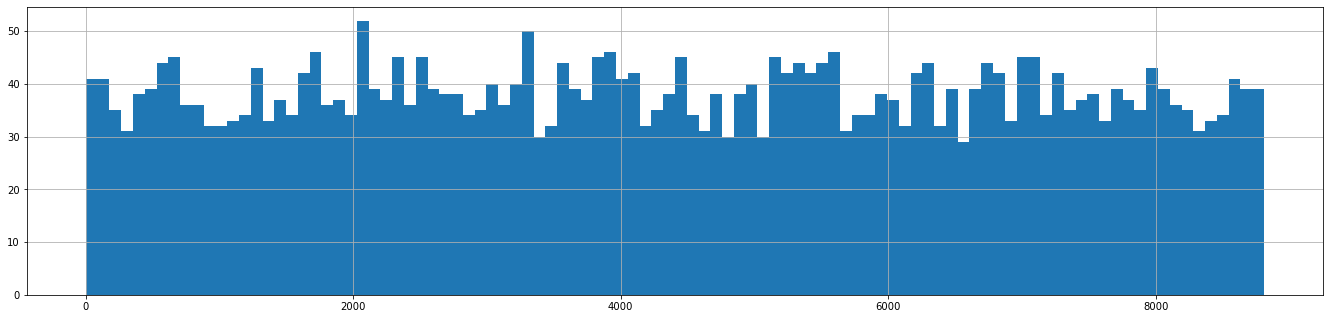

In [32]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
data[data.city == 'Madrid'].ranking.hist(bins=100)

Из данных выше мы видим, что распределение ranking внутри городов более равномерное. Можно попробовать создать признак относительного ранга ресторана в зависимости от максимального ранга в этом городе. Это должно помочь нам выровнять распределение этого признака.

In [33]:
cities = list(data.city.unique())
max_rankings = {}
for city in cities:
    max_rankings.update({city:data[data.city == city].ranking.max()})
data['max_ranking_in_city'] = data.city.map(max_rankings)
data['relative_ranking'] = data.ranking / data.max_ranking_in_city
data.relative_ranking.describe()

count    50000.000000
mean         0.498423
std          0.287871
min          0.000061
25%          0.249061
50%          0.496908
75%          0.747353
max          1.000000
Name: relative_ranking, dtype: float64

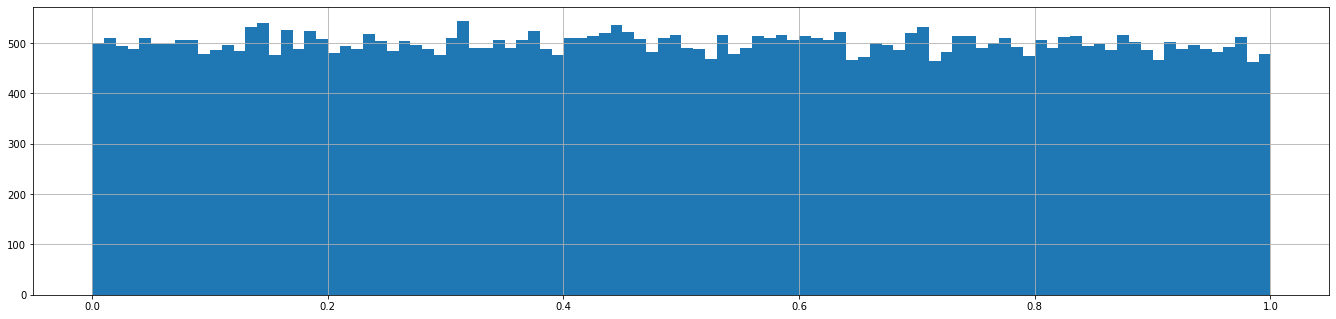

In [34]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
data.relative_ranking.hist(bins=100)

теперь этот признак имеет более равномерное распределение. попробуем его использовать.

In [35]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
#data['Number of Reviews'].fillna(0, inplace=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            50000 non-null  object 
 1   city                     50000 non-null  object 
 2   cuisine_style            50000 non-null  object 
 3   ranking                  50000 non-null  float64
 4   price_range              32639 non-null  object 
 5   number_of_reviews        46800 non-null  float64
 6   reviews                  49998 non-null  object 
 7   url_ta                   50000 non-null  object 
 8   id_ta                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  rating                   50000 non-null  float64
 11  number_of_reviews_isnan  50000 non-null  uint8  
 12  price_range_isnan        50000 non-null  uint8  
 13  cuisine_style_isnan      50000 non-null  uint8  
 14  reviews_isnan         

Рассмотрим следующий столбец price_range. Он имеет несколько значение обозначающих порядок цен в ресторанах. Этот признак имеет упорядоченные значения, поэтому мы можем заменить его на 1, 2 и 3. Пропусков достаточно много. Для упрощения работы заменим их на среднее значение 2 и посмотрим на работу модели. Возможно, в дальнейшем я изменю подход в этом случае.

In [37]:
data.price_range.unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [38]:
data.price_range = data.price_range.str.replace('\$\$\$\$', '3')
data.price_range = data.price_range.str.replace('\$\$\s-\s\$\$\$', '2')
data.price_range = data.price_range.str.replace('\$', '1')
data.price_range = data.price_range.fillna(0)

переведем этот признак в dummy переменные

In [39]:
price_dummy = pd.get_dummies(data.price_range.apply(pd.Series).stack(), prefix = 'price_range_').sum(level=0)
data = pd.concat([data, price_dummy], axis=1, ignore_index=False)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            50000 non-null  object 
 1   city                     50000 non-null  object 
 2   cuisine_style            50000 non-null  object 
 3   ranking                  50000 non-null  float64
 4   price_range              50000 non-null  object 
 5   number_of_reviews        46800 non-null  float64
 6   reviews                  49998 non-null  object 
 7   url_ta                   50000 non-null  object 
 8   id_ta                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  rating                   50000 non-null  float64
 11  number_of_reviews_isnan  50000 non-null  uint8  
 12  price_range_isnan        50000 non-null  uint8  
 13  cuisine_style_isnan      50000 non-null  uint8  
 14  reviews_isnan         

посмотрим на колонку number_of_reviews

In [41]:
data.number_of_reviews.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

как мы видим, есть несколько тысяч пропусков в этом столбце, которые нам нужно проанализировать. так же мы видим очень большой разброс между верхним квартилем и максимумом. это похоже на ситуацию с рангами. скорее всего есть небольшое количество популярных ресторанов с большим количеством отзывов. Основная масса ресторанов имеет не более 115 отзывов.

In [42]:
num_rev_na = data[data.number_of_reviews.isna()]
num_rev_na[num_rev_na.reviews == '[[], []]'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 7 to 49988
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            2023 non-null   object 
 1   city                     2023 non-null   object 
 2   cuisine_style            2023 non-null   object 
 3   ranking                  2023 non-null   float64
 4   price_range              2023 non-null   object 
 5   number_of_reviews        0 non-null      float64
 6   reviews                  2023 non-null   object 
 7   url_ta                   2023 non-null   object 
 8   id_ta                    2023 non-null   object 
 9   sample                   2023 non-null   int64  
 10  rating                   2023 non-null   float64
 11  number_of_reviews_isnan  2023 non-null   uint8  
 12  price_range_isnan        2023 non-null   uint8  
 13  cuisine_style_isnan      2023 non-null   uint8  
 14  reviews_isnan          

In [43]:
num_rev_na[num_rev_na.reviews != '[[], []]'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 74 to 49989
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            1177 non-null   object 
 1   city                     1177 non-null   object 
 2   cuisine_style            1177 non-null   object 
 3   ranking                  1177 non-null   float64
 4   price_range              1177 non-null   object 
 5   number_of_reviews        0 non-null      float64
 6   reviews                  1176 non-null   object 
 7   url_ta                   1177 non-null   object 
 8   id_ta                    1177 non-null   object 
 9   sample                   1177 non-null   int64  
 10  rating                   1177 non-null   float64
 11  number_of_reviews_isnan  1177 non-null   uint8  
 12  price_range_isnan        1177 non-null   uint8  
 13  cuisine_style_isnan      1177 non-null   uint8  
 14  reviews_isnan         

мы видим, что две трети из пропусков соответствуют пустым значениям в отзывах. мы можем их заменить на нули. остальные значения заменим на 1, так как большинство и них содержат один отзыв.

In [44]:
data = data.dropna(subset=['number_of_reviews'], axis=0)
num_rev_na.number_of_reviews = num_rev_na.number_of_reviews.apply(lambda x: 0 if x == "[[], []]" else 1)
data = pd.concat([data, num_rev_na])

рассмотрим последнюю колонку в которой есть пропуски - reviews. Здесь мы видим, что в этой колонке соержатся вложенные списки с отзывами и датами этих отзывов. сделаем разбивку данных таким образом, что бы отзывы и даты были в отдельных колонках основного датафрема. это позволит нам работать с ними.

In [45]:
data.reviews

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49965                                             [[], []]
49972             [['Personal expirence'], ['10/27/2017']]
49986                                             [[], []]
49988                                             [[], []]
49989             [['I love this place!'], ['08/24/2015']]
Name: reviews, Length: 50000, dtype: object

заменим пропуски строками с пустыми списками, по примеру, который мы видим выше.

In [46]:
data.reviews = data.reviews.fillna('[[], []]')

In [47]:
for review in data.reviews:
    try:
        temp = eval(review)
    except:
        print(review)

[['Will certainly be back', nan], ['11/26/2017', '07/27/2017']]
[[nan, 'Good food with decent service'], ['11/21/2017', '07/21/2017']]


выше мы видим, что эти строки вместо значений отзывов содержат в себе NaN. То есть мы имеем дату отзыва но его текст по какой-то причине был утерян. Попраивм эти строки так, чтобы мы могли транформировать всю колонку из строки в список.

In [48]:
data.reviews = data.reviews.apply(lambda x: x.replace('nan', '').replace("[,", "['',").replace('[[], []]', "[['', ''], ['', '']]"))
data.reviews = data.reviews.apply(lambda x: eval(x))

разобьем полученные списки на отдельные колонки

In [49]:
data['first_review'] = data.reviews.apply(lambda x: x[0][0])
data['last_review'] = data.reviews.apply(lambda x: x[0][1] if len(x[0]) == 2 else '')
data['first_review_date'] = data.reviews.apply(lambda x: x[1][0])
data['last_review_date'] = data.reviews.apply(lambda x: x[1][1] if len(x[1]) == 2 else '')
data.first_review_date = pd.to_datetime(data.first_review_date)
data.last_review_date = pd.to_datetime(data.last_review_date)

нам нужно заменить пропуски в датах первого и последнего отзывов. можно попробовать использовать среднее значение соответствующих колонок

In [50]:
data.first_review_date = data.first_review_date.fillna(data.first_review_date.mean()).dt.date
data.last_review_date = data.last_review_date.fillna(data.last_review_date.mean()).dt.date

добавим признаки времени между первым и последним обзором в днях и времени прошедшем после последнего обзора

In [51]:
data['delta_between_reviews'] = (data.last_review_date - data.first_review_date).dt.days

In [52]:
today = date.today()
data['since_last_review'] = (today - data.last_review_date).dt.days

обратимся к колонке городов - city. посмотрим на распределение ресторанов по городам.

In [53]:
percentage_rest_per_city = data.city.value_counts().values / 50000
print(percentage_rest_per_city)
print(len(data.city.value_counts()))

[0.14386 0.12216 0.07626 0.0679  0.0541  0.05388 0.05178 0.03632 0.03294
 0.02886 0.02744 0.02628 0.02372 0.0229  0.02252 0.02066 0.02042 0.0185
 0.01672 0.01638 0.01552 0.0149  0.0137  0.01284 0.0118  0.01108 0.00976
 0.0095  0.0076  0.00526 0.00444]
31


оставим все города и переведем их в dummy переменную

In [54]:
city_dummy = pd.get_dummies(data.city.apply(pd.Series).stack()).sum(level=0)
data = pd.concat([data, city_dummy], axis=1, ignore_index=False)

поработаем с городами. поробуем добавить информации о них и создать новые признаки на их основе

создадим словарь с информацией о том, является ли город столичным

In [55]:
is_capital_dict = {'Paris':1,'Helsinki':1,'Edinburgh':0,'London':1,'Bratislava':1,'Paris':1,'Lisbon':1,'Stockholm':1,
                    'Rome':1,'Milan':0,'Munich':0,'Hamburg':0,'Prague':1,'Vienna':1,'Dublin':1,'Barcelona':0,'Brussels':1,
                    'Oslo':1,'Madrid':1,'Amsterdam':1,'Berlin':1,'Lyon':0,'Athens':1,'Budapest':1,'Warsaw':1,'Oporto':0,
                    'Krakow':0,'Copenhagen':1,'Luxembourg':1,'Zurich':0,'Geneva':1,'Ljubljana':1}

добавим эту информацию в основной датафрейм

In [56]:
data['is_capital'] = data.city.map(is_capital_dict)

добавим информацию о населении городов в словарь и введем этот признак в наш датасет

In [57]:
#источник данных: поисковик google
population_dict = {'Paris':2140526,'Helsinki':643272,'Edinburgh':482005,'London':8982000,'Bratislava':424428,
                   'Lisbon':504718,'Stockholm':975904,'Rome':2873000,'Milan':1352000,'Munich':1472000,
                   'Hamburg':1845000,'Prague':1309000,'Vienna':1897000,'Dublin':1388000,'Barcelona':5575000,
                   'Brussels':174383,'Oslo':681067,'Madrid':6642000,'Amsterdam':821752,'Berlin':3769000,
                   'Lyon':513275,'Athens':664046,'Budapest':1752000,'Warsaw':1708000,'Oporto':214349,
                   'Krakow':779115,'Copenhagen':602481,'Luxembourg':613894,'Zurich':402762,'Geneva':499480,
                   'Ljubljana':279631}

In [58]:
data['population'] = data.city.map(population_dict)/1000

добавим индекс стоимости жизни по городам для определения доступности ресторанов

In [59]:
#источник https://www.numbeo.com/cost-of-living/
cost_of_life_dict = {'Paris':73.15,'Helsinki':92.66,'Edinburgh':81.48,'London':81.48,'Bratislava':48.77,
                   'Lisbon':42.67,'Stockholm':96.58,'Rome':73.15,'Milan':85.35,'Munich':73.15,
                   'Hamburg':60.96,'Prague':36.82,'Vienna':60.96,'Dublin':73.15,'Barcelona':60.96,
                   'Brussels':73.15,'Oslo':104.05,'Madrid':60.96,'Amsterdam':92.66,'Berlin':60.96,
                   'Lyon':60.96,'Athens':48.77,'Budapest':40.42,'Warsaw':40.56,'Oporto':39.62,
                   'Krakow':32.45,'Copenhagen':106.58,'Luxembourg':85.35,'Zurich':123.65,'Geneva':112.41,
                   'Ljubljana':48.77}

In [60]:
data['average_cost_of_meal'] = data.city.map(cost_of_life_dict)

рассчитаем количество ресторанов на одного жителя города

In [61]:
numb_of_rest_dict = dict(data.city.value_counts())
data['num_of_rest'] = data.city.map(numb_of_rest_dict)
data['rest_per_citizen'] = data.num_of_rest / data.population
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,...,Rome,Stockholm,Vienna,Warsaw,Zurich,is_capital,population,average_cost_of_meal,num_of_rest,rest_per_citizen
24532,id_609,Edinburgh,"['Grill', 'Pub', 'Gastropub', 'British', 'Bar'...",610.0,2,53.0,"[[Amazing Food, Great], [01/11/2018, 01/11/2018]]",/Restaurant_Review-g186525-d12949239-Reviews-T...,d12949239,1,...,0,0,0,0,0,0,482.005,81.48,745,1.545627
6052,id_6052,Zurich,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",107.0,2,152.0,"[[Pizza magic, Real italian experience in Zuri...",/Restaurant_Review-g188113-d1020883-Reviews-Da...,d1020883,0,...,0,0,0,0,1,0,402.762,123.65,685,1.700756
46882,id_3588,Rome,['Other Cuisines'],3589.0,0,11.0,"[[Vegan friendly, Cheapest coffee in Rome by p...",/Restaurant_Review-g187791-d12434097-Reviews-C...,d12434097,1,...,1,0,0,0,0,1,2873.000,73.15,2589,0.901149
38193,id_1689,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",1690.0,2,124.0,"[[AMAZING, A wonderful place with friendly sta...",/Restaurant_Review-g187791-d10620243-Reviews-A...,d10620243,1,...,1,0,0,0,0,1,2873.000,73.15,2589,0.901149
43076,id_442,Paris,"['French', 'European', 'Vegetarian Friendly']",443.0,3,493.0,"[[Our 3rd Visit, Modern and interesting. Worth...",/Restaurant_Review-g187147-d2080368-Reviews-Re...,d2080368,1,...,0,0,0,0,0,1,2140.526,73.15,6108,2.853504


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

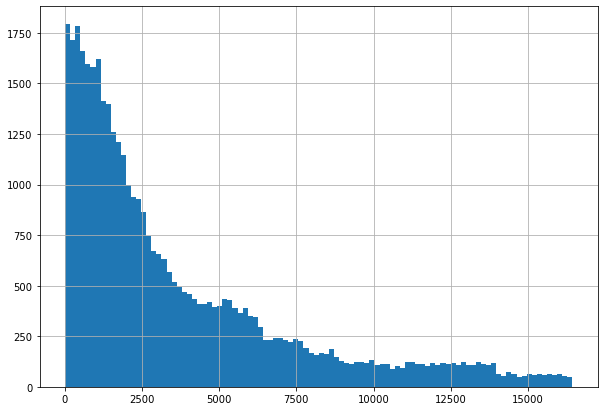

In [62]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

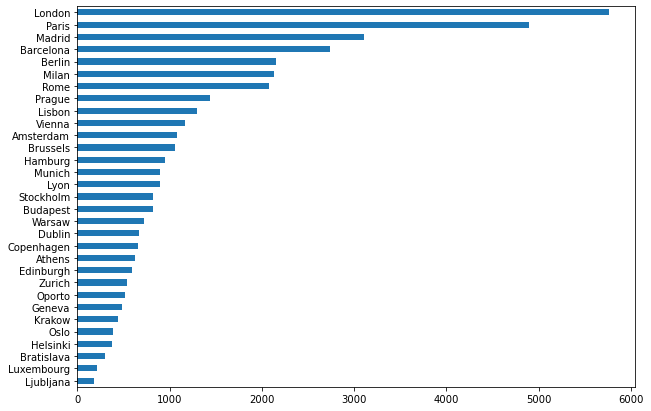

In [63]:
df_train['city'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

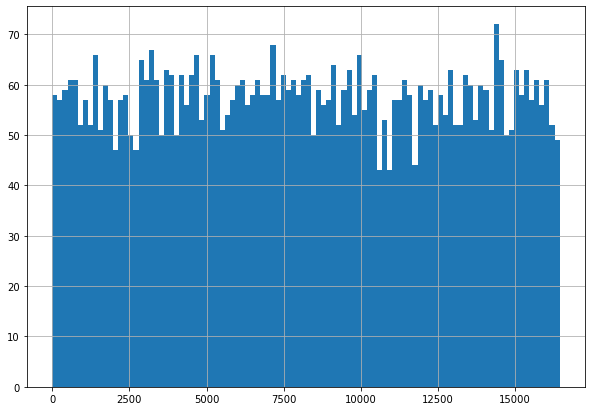

In [64]:
df_train['ranking'][df_train['city'] =='London'].hist(bins=100)

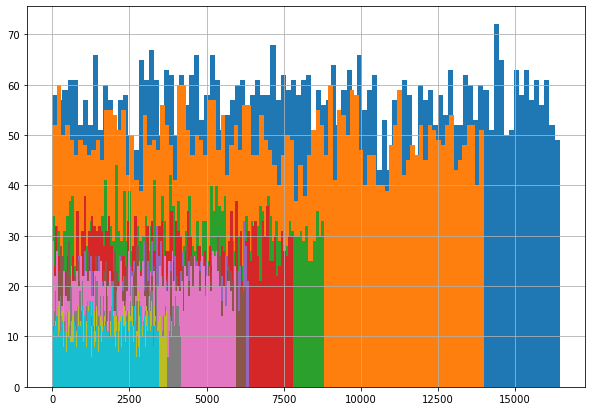

In [65]:
# посмотрим на топ 10 городов
for x in (df_train['city'].value_counts())[0:10].index:
    df_train['ranking'][df_train['city'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


мы создали новый признак relative ranking, что бы изменить ситуацию

### Посмотрим распределение целевой переменной

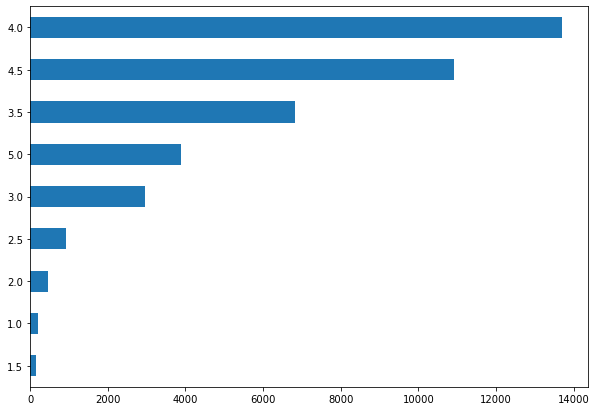

In [66]:
df_train['rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

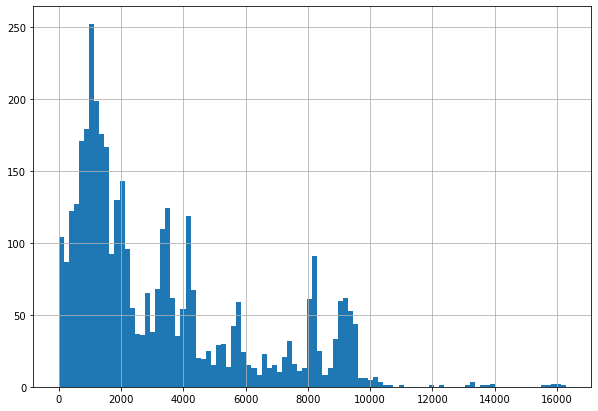

In [67]:
df_train['ranking'][df_train['rating'] == 5].hist(bins=100)

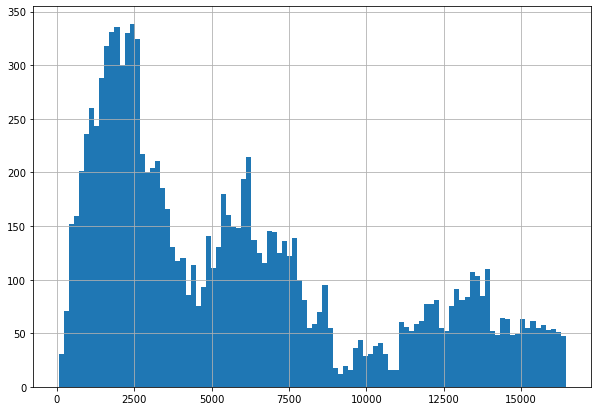

In [68]:
df_train['ranking'][df_train['rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

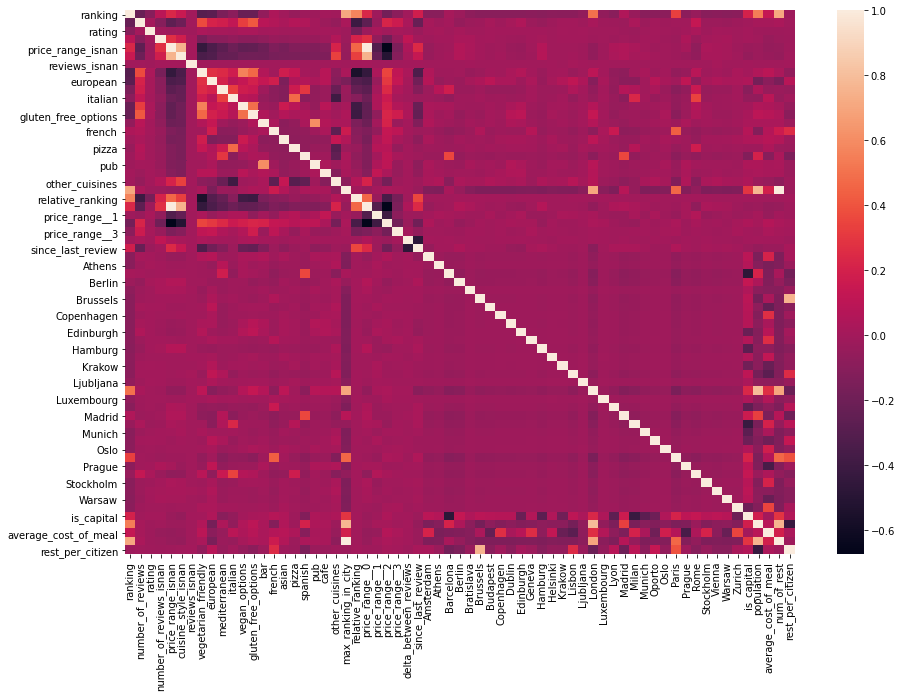

In [69]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [70]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df_train = columns_naming(df_train)
df_test = columns_naming(df_test)

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [71]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['restaurant_id','id_ta',], axis = 1, inplace=True)
    today = date.today()
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['number_of_reviews_isNAN'] = pd.isna(df_output.number_of_reviews).astype('uint8')
    df_output['price_range_isNAN'] = pd.isna(df_output.price_range).astype('uint8')
    df_output['cuisine_style_isNAN'] = pd.isna(df_output.cuisine_style).astype('uint8')
    df_output['reviews_isNAN'] = pd.isna(df_output.reviews).astype('uint8')
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    unique_cuisines = df_output[~df_output.cuisine_style.isna()]['cuisine_style'].astype('str').apply(lambda x: eval(x)).explode()
    unique_cuisines_counts = unique_cuisines.value_counts()
    
    cut_cuisines_limit = 50000 * 0.05 #этот параметр будем подбирать

    main_cuisines = list(unique_cuisines_counts[unique_cuisines_counts > cut_cuisines_limit].index)
    other_cuisines = list(set(unique_cuisines_counts.index) - set(main_cuisines))
    
    df_output.cuisine_style = df_output.cuisine_style.fillna("['Other Cuisines']")
    other_cuisines.append('Other Cuisines')
    
    for item in main_cuisines:
        df_output[item] = df_output.cuisine_style.astype('str').apply(lambda x: 1 if item in x else 0)

    def other_cuisine(cuisine):
        for item in other_cuisines:
            if item in cuisine:
                return 1
        return 0

    df_output['other_cuisines'] = df_output.cuisine_style.astype('str').apply(other_cuisine)
    df_output = columns_naming(df_output)
    
    cities = list(df_output.city.unique())
    max_rankings = {}
    for city in cities:
        max_rankings.update({city:df_output[df_output.city == city].ranking.max()})
    df_output['max_ranking_in_city'] = df_output.city.map(max_rankings)
    
    df_output.price_range = df_output.price_range.str.replace('\$\$\$\$', '3')
    df_output.price_range = df_output.price_range.str.replace('\$\$\s-\s\$\$\$', '2')
    df_output.price_range = df_output.price_range.str.replace('\$', '1')
    df_output.price_range = df_output.price_range.fillna(0)
    
    price_dummy = pd.get_dummies(df_output.price_range.apply(pd.Series).stack(), prefix = 'price_range_').sum(level=0)
    df_output = pd.concat([df_output, price_dummy], axis=1, ignore_index=False)
    
    num_rev_na = df_output[df_output.number_of_reviews.isna()]
    df_output = df_output.dropna(subset=['number_of_reviews'], axis=0)
    num_rev_na.number_of_reviews = num_rev_na.number_of_reviews.apply(lambda x: 0 if x == "[[], []]" else 1)
    df_output = pd.concat([df_output, num_rev_na])
    df_output.reviews = df_output.reviews.fillna('[[], []]')
    df_output.reviews = df_output.reviews.apply(lambda x: x.replace('nan', '').replace("[,", "['',").replace('[[], []]', "[['', ''], ['', '']]"))
    df_output.reviews = df_output.reviews.apply(lambda x: eval(x))
    
    #добавление этой переменной не оказывает значительного влияния на результат. поэтому добавление этой dummy переменной я убрал
    #city_dummy = pd.get_dummies(df_output.city.apply(pd.Series).stack()).sum(level=0)
    #df_output = pd.concat([df_output, city_dummy], axis=1, ignore_index=False)
    
    is_capital_dict = {'Paris':1,'Helsinki':1,'Edinburgh':0,'London':1,'Bratislava':1,'Paris':1,'Lisbon':1,'Stockholm':1,
                      'Rome':1,'Milan':0,'Munich':0,'Hamburg':0,'Prague':1,'Vienna':1,'Dublin':1,'Barcelona':0,'Brussels':1,
                       'Oslo':1,'Madrid':1,'Amsterdam':1,'Berlin':1,'Lyon':0,'Athens':1,'Budapest':1,'Warsaw':1,'Oporto':0,
                      'Krakow':0,'Copenhagen':1,'Luxembourg':1,'Zurich':0,'Geneva':1,'Ljubljana':1}
    
    #источник данных: https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0_%D0%95%D0%B2%D1%80%D0%BE%D0%BF%D1%8B_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_500_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA
    population_dict = {'Paris':2140526,'Helsinki':643272,'Edinburgh':482005,'London':8982000,'Bratislava':424428,
                   'Lisbon':504718,'Stockholm':975904,'Rome':2873000,'Milan':1352000,'Munich':1472000,
                   'Hamburg':1845000,'Prague':1309000,'Vienna':1897000,'Dublin':1388000,'Barcelona':5575000,
                   'Brussels':174383,'Oslo':681067,'Madrid':6642000,'Amsterdam':821752,'Berlin':3769000,
                   'Lyon':513275,'Athens':664046,'Budapest':1752000,'Warsaw':1708000,'Oporto':214349,
                   'Krakow':779115,'Copenhagen':602481,'Luxembourg':613894,'Zurich':402762,'Geneva':499480,
                   'Ljubljana':279631}
    
    #источник https://www.numbeo.com/cost-of-living/
    cost_of_life_dict = {'Paris':73.15,'Helsinki':92.66,'Edinburgh':81.48,'London':81.48,'Bratislava':48.77,
                   'Lisbon':42.67,'Stockholm':96.58,'Rome':73.15,'Milan':85.35,'Munich':73.15,
                   'Hamburg':60.96,'Prague':36.82,'Vienna':60.96,'Dublin':73.15,'Barcelona':60.96,
                   'Brussels':73.15,'Oslo':104.05,'Madrid':60.96,'Amsterdam':92.66,'Berlin':60.96,
                   'Lyon':60.96,'Athens':48.77,'Budapest':40.42,'Warsaw':40.56,'Oporto':39.62,
                   'Krakow':32.45,'Copenhagen':106.58,'Luxembourg':85.35,'Zurich':123.65,'Geneva':112.41,
                   'Ljubljana':48.77}
    
    numb_of_rest_dict = dict(df_output.city.value_counts())
    
    df_output = columns_naming(df_output)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    df_output['relative_ranking'] = df_output.ranking / df_output.max_ranking_in_city
    df_output['first_review'] = df_output.reviews.apply(lambda x: x[0][0])
    df_output['last_review'] = df_output.reviews.apply(lambda x: x[0][1] if len(x[0]) == 2 else '')
    df_output['first_review_date'] = df_output.reviews.apply(lambda x: x[1][0])
    df_output['last_review_date'] = df_output.reviews.apply(lambda x: x[1][1] if len(x[1]) == 2 else '')
    df_output.first_review_date = pd.to_datetime(df_output.first_review_date)
    df_output.last_review_date = pd.to_datetime(df_output.last_review_date)
    df_output.first_review_date = df_output.first_review_date.fillna(df_output.first_review_date.mean()).dt.date
    df_output.last_review_date = df_output.last_review_date.fillna(df_output.last_review_date.mean()).dt.date
    df_output['delta_between_reviews'] = (df_output.last_review_date - df_output.first_review_date).dt.days
    df_output['since_last_review'] = (today - df_output.last_review_date).dt.days
    df_output['is_capital'] = df_output.city.map(is_capital_dict)
    df_output['population'] = df_output.city.map(population_dict)/1000
    df_output['average_cost_of_meal'] = df_output.city.map(cost_of_life_dict)
    df_output['num_of_rest'] = df_output.city.map(numb_of_rest_dict)
    df_output['rest_per_citizen'] = df_output.num_of_rest / df_output.population
    
    
    # ################### 5. Clean #################################################### 
    # попробуем убрать признаки не оказывающие особого влияния
    #drop_columns = ['number_of_reviews_isnan', 'price_range_isnan', 'cuisine_style_isnan',
    #   'reviews_isnan', 'vegetarian_friendly', 'european', 'mediterranean','italian', 'vegan_options','gluten_free_options', 'bar', 'french',
    #   'asian', 'pizza', 'spanish', 'pub', 'cafe', 'other_cuisines','price_range__0', 'price_range__1',
    #   'price_range__2', 'price_range__3','is_capital']
    #df_output.drop(drop_columns, axis = 1, inplace=True)
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [72]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,ranking,number_of_reviews,sample,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,reviews_isnan,vegetarian_friendly,european,...,price_range__2,price_range__3,relative_ranking,delta_between_reviews,since_last_review,is_capital,population,average_cost_of_meal,num_of_rest,rest_per_citizen
36304,542.0,430.0,1,4.0,0,0,0,0,1,0,...,1,0,0.038753,-20,1125,1,2140.526,73.15,6108,2.853504
36259,2379.0,413.0,1,4.0,0,0,0,0,1,0,...,1,0,0.399966,-6,1145,1,2873.000,73.15,2589,0.901149
49010,2919.0,95.0,1,4.5,0,0,0,0,0,0,...,1,0,0.208709,-213,1379,1,2140.526,73.15,6108,2.853504
47933,5389.0,2.0,1,3.5,0,1,1,0,0,0,...,0,0,0.845731,17,1403,1,3769.000,60.96,2705,0.717697
30362,969.0,8.0,1,5.0,0,1,1,0,0,0,...,0,0,0.494388,-89,1273,1,1388.000,73.15,836,0.602305
17258,3713.0,184.0,1,4.0,0,0,0,0,1,0,...,1,0,0.225797,-32,1158,1,8982.000,81.48,7193,0.800824
37295,3000.0,68.0,1,4.0,0,0,0,0,1,0,...,0,0,0.182437,-90,1204,1,8982.000,81.48,7193,0.800824
12427,5127.0,84.0,1,3.5,0,0,0,0,0,0,...,1,0,0.861970,-424,1613,1,2873.000,73.15,2589,0.901149
18116,13019.0,114.0,1,3.0,0,1,1,0,0,0,...,0,0,0.930859,-167,1739,1,2140.526,73.15,6108,2.853504
43738,16269.0,3.0,1,1.5,0,1,1,0,0,0,...,0,0,0.989358,-100,1485,1,8982.000,81.48,7193,0.800824


In [73]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49989
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ranking                  50000 non-null  float64
 1   number_of_reviews        50000 non-null  float64
 2   sample                   50000 non-null  int64  
 3   rating                   50000 non-null  float64
 4   number_of_reviews_isnan  50000 non-null  uint8  
 5   price_range_isnan        50000 non-null  uint8  
 6   cuisine_style_isnan      50000 non-null  uint8  
 7   reviews_isnan            50000 non-null  uint8  
 8   vegetarian_friendly      50000 non-null  int64  
 9   european                 50000 non-null  int64  
 10  mediterranean            50000 non-null  int64  
 11  italian                  50000 non-null  int64  
 12  vegan_options            50000 non-null  int64  
 13  gluten_free_options      50000 non-null  int64  
 14  bar                   

In [74]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [75]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [76]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 34), (40000, 34), (40000, 33), (32000, 33), (8000, 33))

# Model 
Сам ML

In [77]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [78]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [79]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [80]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20498375


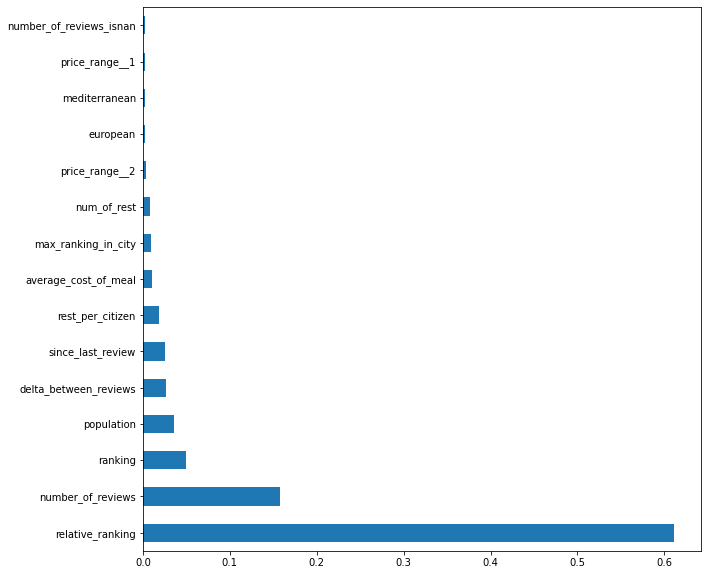

In [81]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [82]:
test_data.sample(10)

,ranking,number_of_reviews,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,reviews_isnan,vegetarian_friendly,european,mediterranean,...,price_range__2,price_range__3,relative_ranking,delta_between_reviews,since_last_review,is_capital,population,average_cost_of_meal,num_of_rest,rest_per_citizen
4519,2503.0,148.0,0.0,0,0,0,0,1,1,0,...,1,0,0.152214,-23,1112,1,8982.000,81.48,7193,0.800824
1857,1317.0,165.0,0.0,0,0,0,0,1,1,0,...,1,0,0.094166,-14,1103,1,2140.526,73.15,6108,2.853504
2179,5622.0,8.0,0.0,0,1,1,0,0,0,0,...,0,0,0.895936,-70,1403,0,1352.000,85.35,2694,1.992604
7363,595.0,72.0,0.0,0,0,0,0,1,1,1,...,1,0,0.142073,-5,1092,1,1309.000,36.82,1816,1.387319
8217,590.0,68.0,0.0,0,0,0,0,1,1,1,...,1,0,0.158730,-12,1158,1,504.718,42.67,1647,3.263208
9764,3431.0,130.0,0.0,0,0,0,0,1,0,0,...,1,0,0.208648,-11,1128,1,8982.000,81.48,7193,0.800824
3008,2621.0,38.0,0.0,0,0,0,0,0,1,0,...,1,0,0.625836,-119,1355,1,1309.000,36.82,1816,1.387319
9599,481.0,245.0,0.0,0,0,0,0,1,1,1,...,1,0,0.245408,-50,1165,1,1388.000,73.15,836,0.602305
8342,8707.0,29.0,0.0,0,0,0,0,0,0,0,...,0,0,0.622551,578,1403,1,2140.526,73.15,6108,2.853504
4788,9604.0,33.0,0.0,0,0,0,0,1,0,0,...,0,0,0.584043,-123,1333,1,8982.000,81.48,7193,0.800824


In [83]:
test_data = test_data.drop(['rating'], axis=1)

In [84]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [85]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [86]:
predict_submission

array([3.1  , 4.21 , 4.145, ..., 3.   , 3.995, 3.   ])

In [87]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.100
1,id_1,4.210
2,id_2,4.145
3,id_3,4.365
4,id_4,4.455
5,id_5,4.355
6,id_6,1.785
7,id_7,4.150
8,id_8,4.600
9,id_9,4.070


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
